In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from model import *
from postprocessingcode import *


In [2]:

plt.style.use('seaborn-muted')
#plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.xmargin'] = .05
plt.rcParams['axes.ymargin'] = .05

fontsize = 12


/var/folders/bm/cj_r3l2j75983rq935h7dwkc0000gn/T/ipykernel_6087/1771481740.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


# Import data

In [3]:


def import_data(path):
    
    #[M, d, _, _] = np.load(path + "Parm_main.npy", allow_pickle=True)
    [f] = np.load(path + "Freq_vector.npy", allow_pickle=True)
    md = np.load(path + "Parm_main.npy", allow_pickle=True)
    data_FAS = np.load(path + "FAS_2D.npy", allow_pickle=True)
    
    n_freq       = len(f)
    
    eps   = 1e-15
    data_main  = np.log(np.asarray(data_FAS) + eps)
    
    return data_main[:,15:99], md[:2,:].T, f[15:99]




# Import data (2D synthetic data generated by Boore model)

In [4]:
direct = os.getcwd()[:-3]
path = direct + "data/"

data, mag_dis, freq = import_data(path)   

n_freq = len(freq)
n_data = data.shape[0]


# Add noise 
noise_level = 0.1
data  = data + noise_level * np.random.normal(size = data.shape)


# Plot data

Text(0.5, 1.0, 'Data')

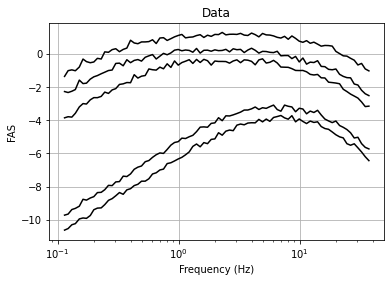

In [5]:
           
plt.plot(freq, data[:5,:].T, color = 'k')
plt.xscale('log')
#plt.yscale('log')

plt.xlabel('Frequency (Hz)')
plt.ylabel('FAS')

plt.title("Data")

#  Data splitting to training, validation, and test dataset

In [6]:

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10


md_train, md_val, data_train, data_val = train_test_split(mag_dis, data, test_size=1 - train_ratio, random_state=1) 
    
md_val, md_test, data_val, data_test = train_test_split(md_val, data_val, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1) 

batch_size = 64



# Anlysis the number of nodes for latent space

In [ ]:

## Inital 
ls1_1 = []
ls1_2 = []

for i in range(1,10):
    latent_space = i
    ls1 = []
    ls2 = []
    for ii in range(20):

        model_AE, model_enc, model_dec = AEModel(latent_space, original_dim=n_freq , alpha = 1e-2)

        
        cc = optimizers.Adam(learning_rate =1e-4)
        model_AE.compile(loss='mean_squared_error', optimizer=cc)
        model_AE.summary()
        es = EarlyStopping(monitor='val_loss', verbose = False, patience = 3) 
        history = model_AE.fit(data_train, data_train, shuffle = True, epochs =400,verbose = False,
                                  batch_size=batch_size, validation_data = (data_val, data_val),
                                  callbacks=[History(),es])
        
        axout = model_AE.predict(data,batch_size = batch_size)

        #ls1.append(np.mean(np.abs(axout-data),0))
        ls1.append(np.mean(np.abs(axout-data)))
        ls2.append(np.median(np.abs(axout-data)))
        print("latentspace : " + str(i) + ", iteration : " + str(ii))

    ls1_1.append(ls1)
    ls1_2.append(ls2)
    


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84)]              0         
                                                                 
 dense (Dense)               (None, 20)                1700      
                                                                 
 dense_1 (Dense)             (None, 15)                315       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
 dense_3 (Dense)             (None, 15)                30        
                                                                 
 dense_4 (Dense)             (None, 20)                320       
                                                                 
 dense_5 (Dense)             (None, 84)                1764  

/Users/rezad.d.esfahani/anaconda3/envs/tf/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-05-25 17:33:38.379958: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


157/157 [==============================] - 0s 381us/step
latentspace : 1, iteration : 0
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 84)]              0         
                                                                 
 dense_6 (Dense)             (None, 20)                1700      
                                                                 
 dense_7 (Dense)             (None, 15)                315       
                                                                 
 dense_8 (Dense)             (None, 1)                 16        
                                                                 
 dense_9 (Dense)             (None, 15)                30        
                                                                 
 dense_10 (Dense)            (None, 20)                320       
                                     

 dense_41 (Dense)            (None, 84)                1764      
                                                                 
Total params: 4,145
Trainable params: 4,145
Non-trainable params: 0
_________________________________________________________________
157/157 [==============================] - 0s 343us/step
latentspace : 1, iteration : 6
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 84)]              0         
                                                                 
 dense_42 (Dense)            (None, 20)                1700      
                                                                 
 dense_43 (Dense)            (None, 15)                315       
                                                                 
 dense_44 (Dense)            (None, 1)                 16        
                                  

                                                                 
 dense_75 (Dense)            (None, 15)                30        
                                                                 
 dense_76 (Dense)            (None, 20)                320       
                                                                 
 dense_77 (Dense)            (None, 84)                1764      
                                                                 
Total params: 4,145
Trainable params: 4,145
Non-trainable params: 0
_________________________________________________________________
157/157 [==============================] - 0s 388us/step
latentspace : 1, iteration : 12
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 84)]              0         
                                                                 
 dense_78 (Dense)            (Non

 dense_108 (Dense)           (None, 20)                1700      
                                                                 
 dense_109 (Dense)           (None, 15)                315       
                                                                 
 dense_110 (Dense)           (None, 1)                 16        
                                                                 
 dense_111 (Dense)           (None, 15)                30        
                                                                 
 dense_112 (Dense)           (None, 20)                320       
                                                                 
 dense_113 (Dense)           (None, 84)                1764      
                                                                 
Total params: 4,145
Trainable params: 4,145
Non-trainable params: 0
_________________________________________________________________
157/157 [==============================] - 0s 339us/step
latentspace : 1, 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 84)]              0         
                                                                 
 dense_144 (Dense)           (None, 20)                1700      
                                                                 
 dense_145 (Dense)           (None, 15)                315       
                                                                 
 dense_146 (Dense)           (None, 2)                 32        
                                                                 
 dense_147 (Dense)           (None, 15)                45        
                                                                 
 dense_148 (Dense)           (None, 20)                320       
                                                                 
 dense_149 (Dense)           (None, 84)                1764      
          

# Latent space analysis

In [ ]:
plt.boxplot(ls1_1, showfliers=False)

plt.xlabel('Number of bottleneck nodes (k)')


# Train the model for 2 nodes in latent space

In [ ]:
#model_AE, model_enc, model_dec = AEModel(2, original_dim=n_freq , alpha = 1e-2)

## Inital 


latent_space = 2

    
model_AE, model_enc, modael_dec = AEModel(latent_space, original_dim=n_freq , alpha = 1e-2)

print("latentspace : " + str(latent_space))


cc = optimizers.Adam(learning_rate =1e-4)
model_AE.compile(loss='mean_squared_error', optimizer=cc)
model_AE.summary()
es = EarlyStopping(monitor='val_loss', verbose = False, patience = 5) 

history = model_AE.fit(data_train, data_train, shuffle = True, epochs = 400,verbose = True,
                       batch_size=batch_size, validation_data = (data_val, data_val),
                       callbacks=[History(),es])


axout = model_AE.predict(data,batch_size = batch_size)



# Train and validation loss

In [ ]:
plt.plot(history.history['loss'],'r', label = 'Training')
plt.plot(history.history['val_loss'],'b', label = 'Validation')
plt.yscale('log')

plt.legend()


# Example of test data and generated data

In [ ]:
predic_test = model_AE.predict(data_test)

plt.loglog(freq,np.power(np.exp(1),data_test[0:5,:].T), color = 'k')
plt.loglog(freq,np.power(np.exp(1),predic_test[0:5,:].T), color ='r')

plt.xlabel("Frequency (Hz)")
plt.ylabel("FAS")

# Bottleneck manifold based on two nodes and different parameters

In [ ]:
plt.figure(figsize = (15, 5))

for i, [d, md, title] in enumerate([[data_train, md_train, "training_data"], [data_val, md_val, "validation_data"], [data_test, md_test, 'test_data']]):
    plt.subplot(1,3,i+1)
    
    btl = model_enc.predict(d)
    
    plt.scatter(btl[:,0], btl[:,1],c=md[:,0],s = 2)
    
    plt.title(title, fontsize = fontsize)
    plt.xlabel("N$_{1}$", fontsize = fontsize)
    plt.ylabel("N$_{2}$", fontsize = fontsize)
    
plt.tight_layout()


# reconstructed data and residual anlysis

In [ ]:

predic_train = model_AE.predict(data_train)

err = predic_train - data_train


In [ ]:
xtrm = 3

fig, (ax1,ax2,ax3) = plt.subplots(3,3,figsize=(12, 9))

for i ,  fv in enumerate([1, 10, 20]):
    
    freq_value, indx = findfreq(freq, fv)

    _=ax1[i].hist(err[:,indx],bins=20, density=True, facecolor='k')
    ax1[i].set_title("f={} Hz, $\sigma$={}".format(np.round(freq_value,1),np.round(np.std(err[:,indx]),1)) ,size = 14)
    ax1[i].set_xlabel("Residual",fontsize = fontsize)
    ax1[i].set_ylabel("Density",fontsize = fontsize)
    ax1[i].set_xlim([-xtrm,xtrm])

    
    bins, stdv, meanv = binning(err, md_train[:,0], 1, 10, indx)
    
    
    ax2[i].scatter(md_train[:,0],err[:,indx],facecolors='none', edgecolors='gray',s=1)
    ax2[i].errorbar(bins, meanv,  yerr= stdv, fmt='--ok', lw=2, capthick=2)
    ax2[i].set_ylim([-xtrm,xtrm])
    ax2[i].set_xlabel('Mw',fontsize = fontsize)
    ax2[i].set_ylabel('FAS residual\n |$\hat x$-x|',fontsize = fontsize)
    ax2[i].tick_params( labelsize = fontsize)
    ax2[i].grid(True,which='both')
    ax2[i].set_xscale('log')

    
    bins, stdv, meanv = binning(err, md_train[:,1], 0.1, 10, indx)
    
    
    ax3[i].scatter(md_train[:,1],err[:,indx],facecolors='none', edgecolors='gray',s=1)
    ax3[i].errorbar(bins, meanv,  yerr= stdv, fmt='--ok', lw=2, capthick=2)
    ax3[i].set_ylim([-xtrm,xtrm])
    ax3[i].set_xlabel('Distance (km)',fontsize = fontsize)
    ax3[i].set_ylabel('FAS residual\n |$\hat x$-x|',fontsize = fontsize)
    ax3[i].tick_params( labelsize = fontsize)
    ax3[i].grid(True,which='both')
    ax3[i].set_xscale('log')

fig.tight_layout()


# Example of original and generated data

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

ylim = [10**(-6), 10]

g1 = [1264,  1225, 1492, 4211]

for i in g1:
    ax.loglog(freq,  np.power(10,predic_train[i,:]))
    
ax.legend([("$M_{W}$ = %.1f, d= %.0f Km"%(np.round(md_train[g1[0],0],1),np.round(md_train[g1[0],1],1))),
          ("$M_{W}$ = %.1f, d= %.0f Km"%(np.round(md_train[g1[1],0],1),np.round(md_train[g1[1],1],1))),
          ("$M_{W}$ = %.1f, d= %.0f Km"%(np.round(md_train[g1[2],0],1),np.round(md_train[g1[2],1],1))),
          ("$M_{W}$ = %.1f, d= %.0f Km"%(np.round(md_train[g1[3],0],1),np.round(md_train[g1[3],1],1)))])

for i in g1:
    ax.loglog(freq, np.power(10,data_train[i,:n_freq]),  color='k', ls= "--")

plt.xlabel("Fequency (Hz)")
plt.ylabel("$FAS (cm/s^2)$")
plt.grid(True,which="both")
fig.tight_layout()
#plt.savefig("FAS2d.eps", dpi = 300)


# Bottleneck interpolation on magnitude and distance

In [ ]:
# Manifold interpolation by using complete data, training dataset or testing dataset 

# Complete dataset
btl = model_enc.predict(data)
mfM, mfR, bt1, bt2 = Manifold_Interpolation(btl, mag_dis)

# Training dataset
#btl = model_enc.predict(data_train)
#mfM, mfR, bt1, bt2 = Manifold_Interpolation(btl, md_train)


#Test dataset
#btl = model_enc.predict(data_test)
#mfM, mfR, bt1, bt2 = Manifold_Interpolation(btl, md_test)

# Test dataset needs also manifold extrapolation and interpolation

# Interval for sampling from interpolated manifold

Rinterval = 1.1
Minterval = .1

manifoldmaping = lambda a,b : Manifoldsampling(mfM, mfR,bt1, bt2, model_dec, a, Minterval, b, Rinterval)


# Example of sampling from manifold based on magnitude and distance

In [ ]:
m = [4.5, 5.5, 6]
R = [30, 30, 30]


fig, (ax1,ax2) = plt.subplots(2,3,figsize=(12, 6))

for i in range(3):
    
    kl = ax1[i]
    
    sm1,sm2, cm1 = manifoldmaping( m[i], R[i])
    means = np.mean(cm1,0)
    stds = np.std(cm1,0)
    
    sm1 = np.float32(sm1)
    sm1[sm1==0] = np.NaN

    
    kl.imshow(- sm2 /1 ,aspect='auto',cmap = plt.cm.RdYlBu,extent=(min(bt1),max(bt1),min(bt2), max(bt2)))
    kl.imshow(-sm1 * 10 ,aspect='auto',cmap = plt.cm.gray,extent=(min(bt1),max(bt1),min(bt2), max(bt2)), alpha = 1)
    
    kl.set_title(" $M_w$={}, d={} km".format(np.round(m[i],1), np.round(R[i],0)) ,size = 16)
    kl.set_xlabel("$N_{1}$",fontsize = 16)
    kl.set_ylabel("$N_{2}$",fontsize = 16)

    kl = ax2[i]
    

    kl.loglog(freq,np.power(np.exp(1),means),'k-')
    kl.fill_between(freq, np.power(np.exp(1),means-stds), np.power(np.exp(1),means+stds),color='gray',alpha=0.5)
    kl.grid(True,which="both")

    kl.set_ylim([1e-2,100])
    kl.set_ylabel("FAS (cm/$s^2$)",fontsize = 16)
    kl.set_xlabel("Frequency (Hz)",fontsize = 16)


fig.tight_layout()
#plt.savefig('genrativemode_2d.png', dpi = 500)


# Generate data based on decoder for each scenaro and calculate residual

In [ ]:


freq_value1, indx1 = findfreq(freq, 1)
freq_value2, indx2 = findfreq(freq, 10)
freq_value3, indx3 = findfreq(freq, 20)


resmatrix = residualanalysis(data_train, md_train, manifoldmaping )

a1 = resmatrix[:, indx1]
a2 = resmatrix[:, indx2]
a3 = resmatrix[:, indx3]
    

# Plot residual analysis for each three frequencies and histogram of residual

In [ ]:

xtrm = 3

fig, (ax1,ax2,ax3) = plt.subplots(3,3,figsize=(12, 9))

for i , [var, freq_value] in enumerate([[a1,freq_value1], [a2,freq_value2], [a3,freq_value3]]):

    kl = ax1[i]
    _=kl.hist(var,bins= 10, density=True, facecolor='k')
    kl.set_title("f={} Hz, $\sigma$={}".format(np.round(freq_value,1),np.round(np.std(var),1)) ,size = 14)
    kl.set_xlabel("Residual",fontsize = fontsize)
    kl.set_ylabel("Density",fontsize = fontsize)
    kl.set_xlim([-xtrm,xtrm])

    
    bins, stdv, meanv = binning(var, md_train[:,0], 1, 10, None)
    
    kl = ax2[i]
    kl.scatter(md_train[:,0],var,facecolors='none', edgecolors='gray',s=1)
    kl.errorbar(bins, meanv,  yerr= stdv, fmt='--ok', lw=2, capthick=2)
    kl.set_ylim([-xtrm,xtrm])
    kl.set_xlabel('Mw',fontsize = fontsize)
    kl.set_ylabel('FAS residual\n |$\hat x$-x|',fontsize = fontsize)
    kl.tick_params( labelsize = fontsize)
    kl.grid(True,which='both')
    kl.set_xscale('log')

    bins, stdv, meanv = binning(var, md_train[:,1], 1, 10, None)
    
    kl = ax3[i]
    kl.scatter(md_train[:,1],var,facecolors='none', edgecolors='gray',s=1)
    kl.errorbar(bins, meanv,  yerr= stdv, fmt='--ok', lw=2, capthick=2)
    kl.set_ylim([-xtrm,xtrm])
    kl.set_xlabel('Distance (km)',fontsize = fontsize)
    kl.set_ylabel('FAS residual\n |$\hat x$-x|',fontsize = fontsize)
    kl.tick_params( labelsize = fontsize)
    kl.grid(True,which='both')
    kl.set_xscale('log')
    
fig.tight_layout()

#plt.savefig('synresidual2s.png', dpi = 500)



# Residual analysis for test data

In [ ]:

freq_value1, indx1 = findfreq(freq, 1)
freq_value2, indx2 = findfreq(freq, 10)
freq_value3, indx3 = findfreq(freq, 20)



resmatrix = residualanalysis(data_test, md_test, manifoldmaping )

a1 = resmatrix[:, indx1]
a2 = resmatrix[:, indx2]
a3 = resmatrix[:, indx3]
    

In [ ]:

xtrm = 3

fig, (ax1,ax2,ax3) = plt.subplots(3,3,figsize=(12, 9))

for i , [var, freq_value] in enumerate([[a1,freq_value1], [a2,freq_value2], [a3,freq_value3]]):

    kl = ax1[i]
    _=kl.hist(var,bins=10, density=True, facecolor='k')
    kl.set_title("f={} Hz, $\sigma$={}".format(np.round(freq_value,1),np.round(np.std(var),1)) ,size = 14)
    kl.set_xlabel("Residual",fontsize = fontsize)
    kl.set_ylabel("Density",fontsize = fontsize)
    kl.set_xlim([-xtrm,xtrm])

    
    bins, stdv, meanv = binning(var, md_test[:,0], 1, 10, None)
    
    kl = ax2[i]
    kl.scatter(md_test[:,0],var,facecolors='none', edgecolors='gray',s=1)
    kl.errorbar(bins, meanv,  yerr= stdv, fmt='--ok', lw=2, capthick=2)
    kl.set_ylim([-xtrm,xtrm])
    kl.set_xlabel('Mw',fontsize = fontsize)
    kl.set_ylabel('FAS residual\n |$\hat x$-x|',fontsize = fontsize)
    kl.tick_params( labelsize = fontsize)
    kl.grid(True,which='both')
    kl.set_xscale('log')

    bins, stdv, meanv = binning(var, md_test[:,1], 1, 10, None)
    
    kl = ax3[i]
    kl.scatter(md_test[:,1],var,facecolors='none', edgecolors='gray',s=1)
    kl.errorbar(bins, meanv,  yerr= stdv, fmt='--ok', lw=2, capthick=2)
    kl.set_ylim([-xtrm,xtrm])
    kl.set_xlabel('Distance (km)',fontsize = fontsize)
    kl.set_ylabel('FAS residual\n |$\hat x$-x|',fontsize = fontsize)
    kl.tick_params( labelsize = fontsize)
    kl.grid(True,which='both')
    kl.set_xscale('log')
    
fig.tight_layout()

#plt.savefig('synresidual2s.png', dpi = 500)
